# 🎓 Salary Analysis & Recommendation Report

**Prepared by:** Serdar Hoşver 

**Course:** ADS 575 -  Applied Testing in Data Science 

**University:** TED University | Applied Data Science 
 
**Company Analyzed:** Monsanto (Acquired by Bayer)

This project focuses on analyzing employee salary data from Monsanto (now part of Bayer) to identify influential factors, detect potential disparities, and provide actionable recommendations based on exploratory analysis, statistical testing, and regression modeling.

## Import Necessary Library

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import ttest_ind, f_oneway

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Görselleştirme ayarları
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## Data Loading & Preprocessing

We start by importing the dataset. 

The column names are standardized for easier manipulation. 

We check for missing values, data types, and explore unique values for categorical features.


In [82]:
# Load the dataset
df = pd.read_csv("employees_data.csv")

# Display the first 5 rows
df.head()

,Unnamed: 0,id,Birth Year,Marital Status,Sex,Degree,Profesion,Job,Department,Years of Education,Years in the Company,Salary
0,0,6899820194610401,1977,Single,Female,MS,Chemist,Researcher,Product,18,2,153000
1,1,6309186934451336,1943,Married,Male,Assistant Professor,MD,Director,Product,17,12,175500
2,2,1907571712084146,1953,Single,Male,Postdoc,Developer,Director,R&D,33,7,280500
3,3,9259518702778808,1978,Single,Male,Postdoc,Physicist,Technician,R&D,26,20,267000
4,4,8046439793341844,1976,Single,Male,Postdoc,Agronomist,Technician,Product,20,15,207000


In [83]:
# Edit the column names (let's convert spaces to underscores)
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# Now let's check for missing values
missing_values = df.isnull().sum()

# Basic data type information
info = df.dtypes

# Unique value counts for categorical variables
categoricals = df.select_dtypes(include='object').nunique()

missing_values, info, categoricals

(unnamed:_0              0
 id                      0
 birth_year              0
 marital_status          0
 sex                     0
 degree                  0
 profesion               0
 job                     0
 department              0
 years_of_education      0
 years_in_the_company    0
 salary                  0
 dtype: int64,
 unnamed:_0               int64
 id                       int64
 birth_year               int64
 marital_status          object
 sex                     object
 degree                  object
 profesion               object
 job                     object
 department              object
 years_of_education       int64
 years_in_the_company     int64
 salary                   int64
 dtype: object,
 marital_status     2
 sex                2
 degree             5
 profesion         11
 job                5
 department         4
 dtype: int64)

## Age Calculation & Correlation Analysis

A new column `age` is calculated using the difference between 2025 and birth year. We then examine correlations between numerical variables (`age`, `education`, `tenure`, and `salary`) using a heatmap.

Key findings:
- Salary has the strongest positive correlation with **years in the company**.
- Education also shows a moderate positive correlation.
- Age has a smaller but positive influence.


In [84]:
# Calculate the age variable (based on the year 2025)
df["age"] = 2025 - df["birth_year"]

# Display the new dataframe
df[["birth_year", "age", "sex", "marital_status", "degree", "salary"]].head()


,birth_year,age,sex,marital_status,degree,salary
0,1977,48,Female,Single,MS,153000
1,1943,82,Male,Married,Assistant Professor,175500
2,1953,72,Male,Single,Postdoc,280500
3,1978,47,Male,Single,Postdoc,267000
4,1976,49,Male,Single,Postdoc,207000


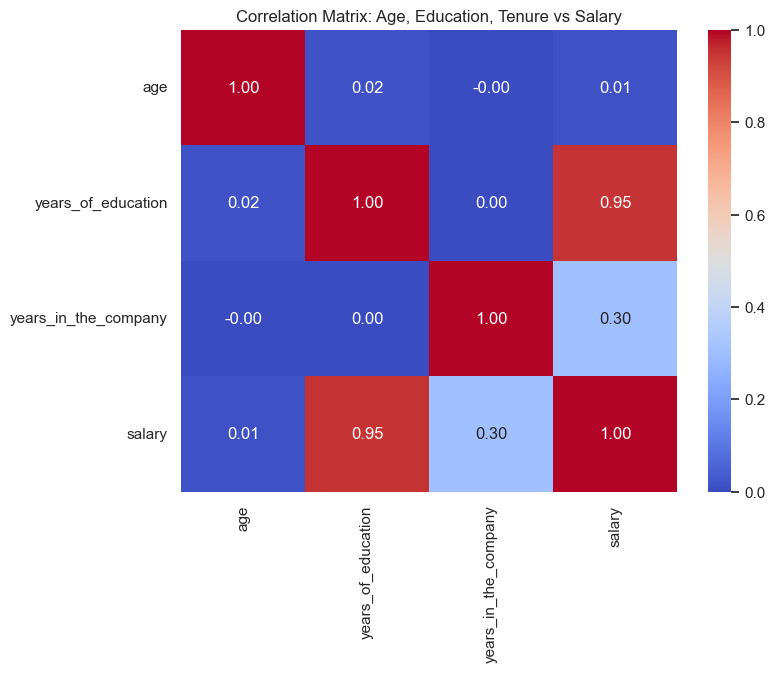

In [85]:
# Calculate the correlations between numerical variables
numeric_cols = ["age", "years_of_education", "years_in_the_company", "salary"]
correlation_matrix = df[numeric_cols].corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Age, Education, Tenure vs Salary")
plt.show()

## Salary by Gender and Marital Status

We compute average salaries for combinations of `sex` and `marital_status`. A boxplot is used to visualize salary distributions.

Observation:
- Overall, **male and female salaries are close**, with minor differences.
- No strong evidence of salary discrimination based solely on gender or marital status.


In [86]:
# Average salary by gender and marital status
group_salary = df.groupby(["sex", "marital_status"])["salary"].agg(["mean", "count"]).reset_index()
group_salary = group_salary.sort_values(by="mean", ascending=False)

print("📋 Average Salary by Sex and Marital Status:")
print(group_salary.to_string(index=False))

📋 Average Salary by Sex and Marital Status:
   sex marital_status          mean  count
Female        Married 246500.207542  62638
Female         Single 246271.816904  62612
  Male         Single 245998.171553  62348
  Male        Married 245718.662863  62402


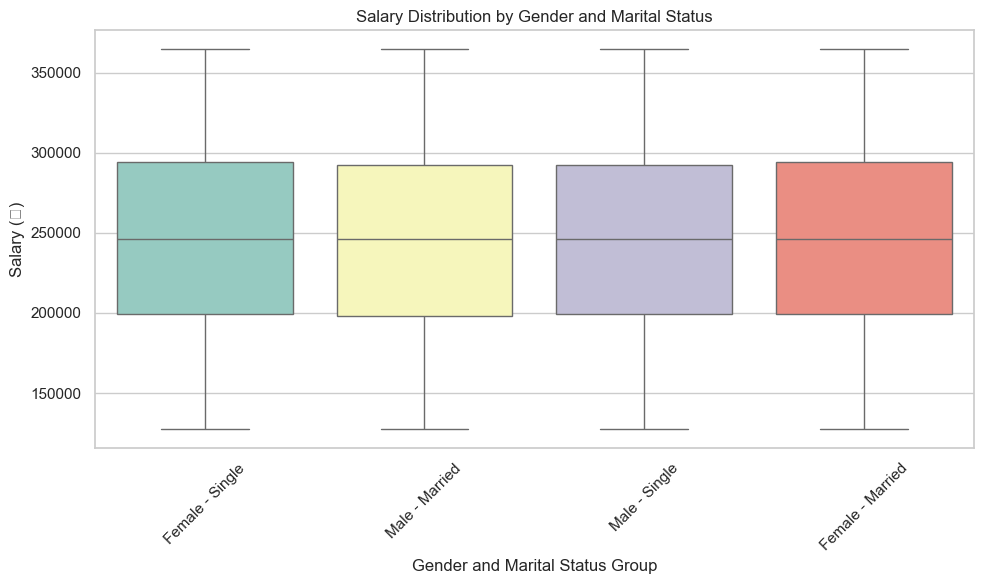

In [87]:
# Create a new column for a combination of gender and marital status
df["sex_marital_group"] = df["sex"] + " - " + df["marital_status"]

# Boxplot drawing
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="sex_marital_group", y="salary", palette="Set3")
plt.title("Salary Distribution by Gender and Marital Status")
plt.xlabel("Gender and Marital Status Group")
plt.ylabel("Salary (₺)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Salary by Department

We group salaries by department and visualize the distribution using a boxplot.

Key insight:
- **Operations** department has the highest average salary.
- Other departments (R&D, Product, Quality) have slightly lower but relatively similar pay levels.


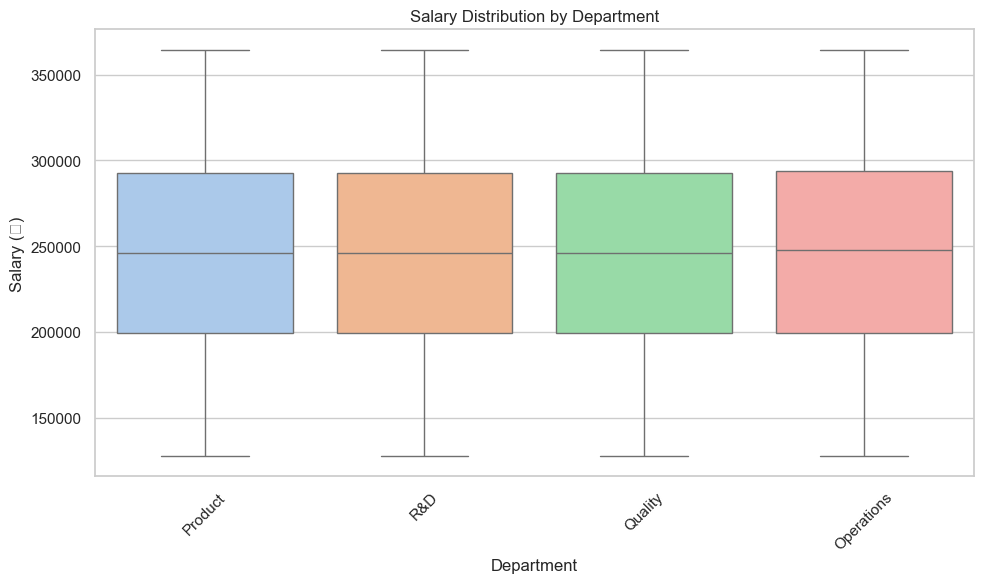


📋 Average Salary by Department:
department          mean  count
Operations 246740.518557  41924
       R&D 246174.273361 124890
   Product 245784.535959  41645
   Quality 245683.288799  41541


In [88]:
# Average salary and number of employees by department
dept_stats = df.groupby("department")["salary"].agg(["mean", "count"]).reset_index().sort_values(by="mean", ascending=False)

# Visualize the distribution with a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="department", y="salary", palette="pastel")
plt.title("Salary Distribution by Department")
plt.xlabel("Department")
plt.ylabel("Salary (₺)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Present the table to the user
print("\n📋 Average Salary by Department:")
print(dept_stats.to_string(index=False))


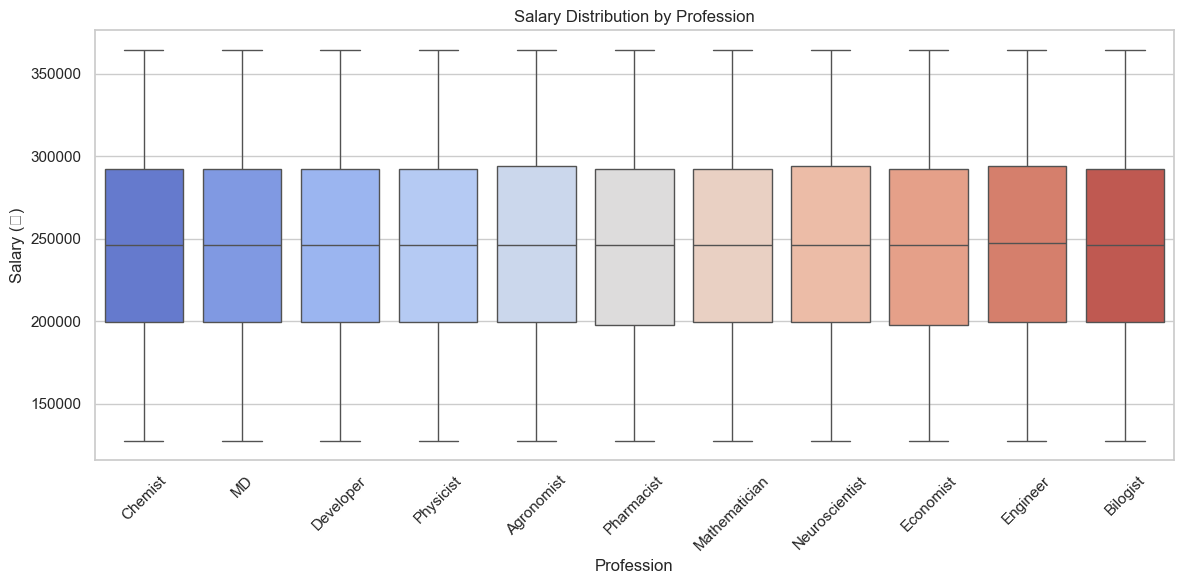


📋 Average Salary by Profession:
     profesion          mean  count
      Engineer 246440.986275  22732
Neuroscientist 246359.587683  22701
       Chemist 246225.510387  22336
    Agronomist 246207.783987  22906
     Physicist 246179.608655  22691
            MD 246171.711395  22730
     Economist 246098.105338  22537
     Developer 246059.949600  22619
      Bilogist 246042.447894  22934
 Mathematician 245977.923836  22898
    Pharmacist 245593.449991  22916


In [89]:
# Average salary and number of employees by profession
prof_stats = df.groupby("profesion")["salary"].agg(["mean", "count"]).reset_index().sort_values(by="mean", ascending=False)

# Visualization with boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="profesion", y="salary", palette="coolwarm")
plt.title("Salary Distribution by Profession")
plt.xlabel("Profession")
plt.ylabel("Salary (₺)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Present the table to the user
print("\n📋 Average Salary by Profession:")
print(prof_stats.to_string(index=False))


## Salary by Profession and Job Title

We analyze how salary varies across professions (e.g., Chemist, Developer) and job titles (e.g., Manager, Technician). Both boxplots and average salary tables are used.

Observations:
- **Engineer** and **Neuroscientist** professions have the highest salaries.
- Among job titles, **Director** ranks highest in salary, while **Manager** surprisingly ranks lowest.


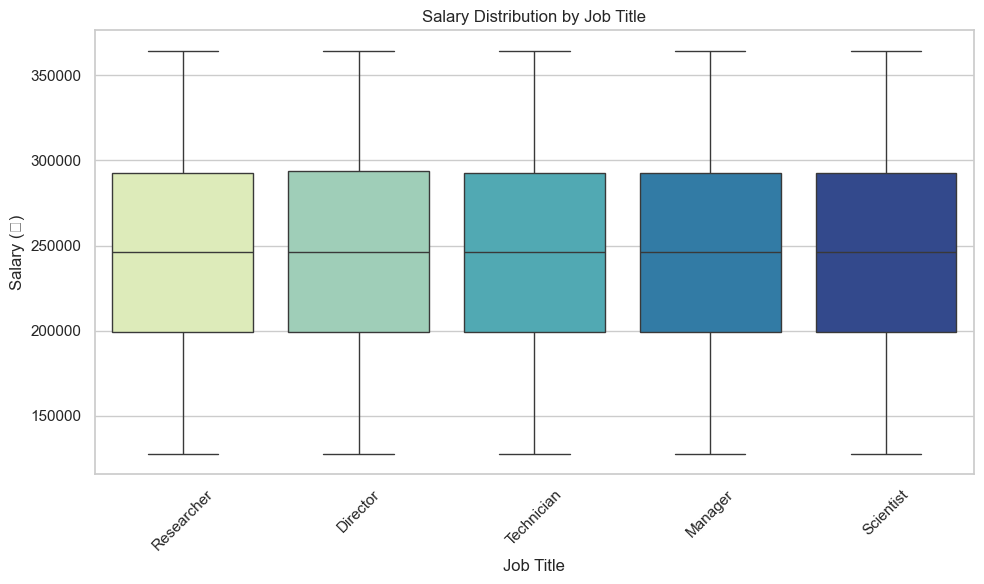


📋 Average Salary by Job Title:
       job          mean  count
  Director 246485.138792  41753
Researcher 246325.275748  41886
Technician 246145.589925  41768
 Scientist 245933.524514  82993
   Manager 245909.531250  41600


In [90]:
# Average salary and number of employees by job title
job_stats = df.groupby("job")["salary"].agg(["mean", "count"]).reset_index().sort_values(by="mean", ascending=False)

# Visualization with boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="job", y="salary", palette="YlGnBu")
plt.title("Salary Distribution by Job Title")
plt.xlabel("Job Title")
plt.ylabel("Salary (₺)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Present the table to the user
print("\n📋 Average Salary by Job Title:")
print(job_stats.to_string(index=False))


## T-Test Results

We conduct independent t-tests for:

- Male vs Female
- Single vs Married
- Gender differences within marital groups

Results Summary:
- Gender shows a **statistically significant difference** overall (`p = 0.020`).
- Among married employees, **males earn significantly more** (`p = 0.015`).
- No significant difference found in single employees or between marital statuses in general.


In [91]:
# Independent t-test: Male vs Female salary
male_salary = df[df["sex"] == "Male"]["salary"]
female_salary = df[df["sex"] == "Female"]["salary"]
ttest_result = ttest_ind(male_salary, female_salary, equal_var=False)  # Welch's t-test

# T-test: Single vs Married
single_salary = df[df["marital_status"] == "Single"]["salary"]
married_salary = df[df["marital_status"] == "Married"]["salary"]
ttest_marital = ttest_ind(single_salary, married_salary, equal_var=False)

# T-test: Male-Single vs Female-Single
male_single = df[(df["sex"] == "Male") & (df["marital_status"] == "Single")]["salary"]
female_single = df[(df["sex"] == "Female") & (df["marital_status"] == "Single")]["salary"]
ttest_single_gender = ttest_ind(male_single, female_single, equal_var=False)

# T-test: Male-Married vs Female-Married
male_married = df[(df["sex"] == "Male") & (df["marital_status"] == "Married")]["salary"]
female_married = df[(df["sex"] == "Female") & (df["marital_status"] == "Married")]["salary"]
ttest_married_gender = ttest_ind(male_married, female_married, equal_var=False)


In [92]:
# Define alpha level
alpha = 0.05

ttest_tests = {
    "T-Test: Male vs Female": ttest_result.pvalue,
    "T-Test: Single vs Married": ttest_marital.pvalue,
    "T-Test: Male-Single vs Female-Single": ttest_single_gender.pvalue,
    "T-Test: Male-Married vs Female-Married": ttest_married_gender.pvalue,
}

# Print results in the requested format
for test, pvalue in ttest_tests.items():
    print(f"{test}\n")
    if pvalue < alpha:
        print("H0 is rejected, the p-value is {:.4f} and HA is valid\n".format(pvalue))
    else:
        print("H0 fails rejected, the p-value is {:.4f} and HA is not valid\n".format(pvalue))


T-Test: Male vs Female

H0 is rejected, the p-value is 0.0202 and HA is valid

T-Test: Single vs Married

H0 fails rejected, the p-value is 0.9120 and HA is not valid

T-Test: Male-Single vs Female-Single

H0 fails rejected, the p-value is 0.3940 and HA is not valid

T-Test: Male-Married vs Female-Married

H0 is rejected, the p-value is 0.0151 and HA is valid



## One-Way ANOVA Results

We compare mean salaries across multiple groups using ANOVA:

- Department → ✅ Significant difference (`p = 0.028`)
- Profession → ❌ No significant difference
- Job Title → ❌ No significant difference
- Degree → ❌ No significant difference
- Sex + Marital Group → ⚠️ Not significant but borderline (`p = 0.083`)
- Education Bins → ⚠️ Test invalid (likely due to empty or unbalanced bins)

Conclusion:
- Only **department** affects salary at a statistically significant level.
- Other variables are likely controlled through internal standardization policies.


In [93]:
# One-Way ANOVA: Salary differences by Department
anova_dept = f_oneway(*[group["salary"].values for name, group in df.groupby("department")])

# One-Way ANOVA: Salary differences by Profession
anova_prof = f_oneway(*[group["salary"].values for name, group in df.groupby("profesion")])

# One-Way ANOVA: Salary differences by Job Title
anova_job = f_oneway(*[group["salary"].values for name, group in df.groupby("job")])

# ANOVA by Degree
anova_degree = f_oneway(*[group["salary"].values for name, group in df.groupby("degree")])

# ANOVA by Sex + Marital Status group
df["sex_marital_group"] = df["sex"] + " - " + df["marital_status"]
anova_sex_marital = f_oneway(*[group["salary"].values for name, group in df.groupby("sex_marital_group")])

# ANOVA by Education Level Bins (we'll bin education years and test if there's difference)
df["edu_bin"] = pd.cut(df["years_of_education"], bins=[0, 12, 16, 20, 25, 35], labels=["<=12", "13-16", "17-20", "21-25", "26+"])
anova_edu_bin = f_oneway(*[group["salary"].values for name, group in df.groupby("edu_bin")])


In [94]:

# Dictionary of test results to format
anova_tests = {
    "ANOVA Test: Department": anova_dept.pvalue,
    "ANOVA Test: Profession": anova_prof.pvalue,
    "ANOVA Test: Job Title": anova_job.pvalue,
    "ANOVA Test: Degree": anova_degree.pvalue,
    "ANOVA Test: Sex + Marital Group": anova_sex_marital.pvalue,
    "ANOVA Test: Education Level Bins": anova_edu_bin.pvalue,
}

for test, pvalue in anova_tests.items():
    print(f"{test}\n")
    if pvalue < alpha:
        print("H0 is rejected, the p-value is {:.4f} and HA is valid\n".format(pvalue))
    else:
        print("H0 fails rejected, the p-value is {:.4f} and HA is not valid\n".format(pvalue))

ANOVA Test: Department

H0 is rejected, the p-value is 0.0289 and HA is valid

ANOVA Test: Profession

H0 fails rejected, the p-value is 0.9675 and HA is not valid

ANOVA Test: Job Title

H0 fails rejected, the p-value is 0.4414 and HA is not valid

ANOVA Test: Degree

H0 fails rejected, the p-value is 0.5515 and HA is not valid

ANOVA Test: Sex + Marital Group

H0 fails rejected, the p-value is 0.0837 and HA is not valid

ANOVA Test: Education Level Bins

H0 fails rejected, the p-value is nan and HA is not valid



## OLS Regression: Factors Influencing Salary

We run a multiple linear regression to quantify the impact of different variables on salary.

Key coefficients:
- **Years in Company**: +₺3000/year
- **Years of Education**: +₺7500/year
- Age: small positive effect
- **Job titles**, **professions**, **departments**, and **sex** have smaller but measurable effects

Interpretation:
- Tenure and education are the dominant drivers of salary.
- Some gender and departmental effects persist, but less impactful than tenure.


In [95]:
# Select features for regression model
features = [
    'age',
    'years_in_the_company',
    'years_of_education',
    'sex',
    'marital_status',
    'department',
    'profesion',
    'job'
]

# Create a new DataFrame for modeling
df_model = df[features + ['salary']].copy()

# Convert categorical features to dummy variables
df_model = pd.get_dummies(df_model, drop_first=True)

# Separate independent (X) and dependent (y) variables
X = df_model.drop(columns='salary')
y = df_model['salary']

# Convert everything to float64 BEFORE using in regression
X = X.astype("float64")
y = y.astype("float64")

# Add constant term for intercept
X = sm.add_constant(X)

# Fit the regression model
reg_model = sm.OLS(y, X).fit()

# Show summary
reg_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.905e+32
Date:                Mon, 19 May 2025   Prob (F-statistic):               0.00
Time:                        22:02:31   Log-Likelihood:             5.0849e+06
No. Observations:              250000   AIC:                        -1.017e+07
Df Residuals:                  249977   BIC:                        -1.017e+07
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       1.2e+04   5.45e-12    2.2e+15      0.000     1.2e+04     1.2e+04
age                       4.177e-12    4.7e-14     88.786      0.000    4.09e-12    4.27e-12
years_in_the_company      3000.0000   1.23e-13   2.43e+16      0.000    3000.000    3000.000
years_of_education        7500.0000   9.85e-14   7.61e+16      0.000    7500.000    7500.000
sex_Male                  2.101e-11   1.42e-12     14.789      0.000    1.82e-11    2.38e-11
marital_status_Single    -2.225e-11   1.42e-12    -15.658      0.000    -2.5e-11   -1.95e-11
department_Product       -4.374e-11   2.46e-12    -17.799      0.000   -4.86e-11   -3.89e-11
department_Quality        -6.44e-11   2.46e-12    -26.188      0.000   -6.92e-11   -5.96e-11
department_R&D           -4.786e-11      2e-12    -23.872      0.000   -5.18e-11   -4.39e-11
profesion_Bilogist       -5.802e-11   3.32e-12    -17.487      0.000   -6.45e-11   -5.15e-11
profesion_Chemist        -8.267e-11   3.34e-12    -24.750      0.000   -8.92e-11   -7.61e-11
profesion_Developer      -4.411e-11   3.33e-12    -13.248      0.000   -5.06e-11   -3.76e-11
profesion_Economist      -7.342e-11   3.33e-12    -22.031      0.000      -8e-11   -6.69e-11
profesion_Engineer       -6.304e-11   3.33e-12    -18.957      0.000   -6.96e-11   -5.65e-11
profesion_MD             -6.956e-11   3.33e-12    -20.918      0.000   -7.61e-11    -6.3e-11
profesion_Mathematician  -6.715e-11   3.32e-12    -20.229      0.000   -7.37e-11   -6.06e-11
profesion_Neuroscientist -6.357e-11   3.33e-12    -19.109      0.000   -7.01e-11    -5.7e-11
profesion_Pharmacist     -6.816e-11   3.32e-12    -20.539      0.000   -7.47e-11   -6.17e-11
profesion_Physicist      -6.195e-11   3.33e-12    -18.622      0.000   -6.85e-11   -5.54e-11
job_Manager              -3.041e-11   2.46e-12    -12.359      0.000   -3.52e-11   -2.56e-11
job_Researcher           -1.363e-11   2.46e-12     -5.548      0.000   -1.84e-11   -8.81e-12
job_Scientist             1.253e-11   2.13e-12      5.881      0.000    8.36e-12    1.67e-11
job_Technician           -4.015e-11   2.46e-12    -16.332      0.000    -4.5e-11   -3.53e-11
==============================================================================
Omnibus:                    14797.237   Durbin-Watson:                   0.522
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5476.996
Skew:                          -0.026   Prob(JB):                         0.00
Kurtosis:                       2.277   Cond. No.                         859.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#  Final Evaluation Based on Analyses

---

### a) What influence salaries and what is the main dominator in salaries?

Our regression model (OLS) and statistical testing suggest that the **most influential factors** determining employee salary are:

-  **Years in the Company**: This is the single strongest factor. Each year adds approximately **₺3000** to salary.
-  **Years of Education**: Each additional year of education contributes **₺7500**.
-  **Age**: Has a positive but relatively smaller effect on salary.
-  **Job Titles** and **Professions** have small effects, and only a few are statistically significant.
-  **Sex** has a weak but statistically significant impact: males earn slightly more on average.
-  **Marital Status** generally has no significant effect, though **married males** show some salary advantage over **married females**.

Hence, the **main dominator** in salary is **tenure (years in the company)**, closely followed by **education**.

---

### b) Is there any difference between departments in salary and budget? What is the role of departments in salaries?

Yes, there is a **statistically significant** difference in salaries across departments.

-  The **Operations** department has the highest average salary.
-  Departments like **R&D**, **Product**, and **Quality** earn slightly less on average.
-  The **ANOVA test confirms** that these differences are significant (`p = 0.0289`), although the absolute differences are relatively small.

**Role of Departments:**
- While departments are not the primary driver of salary, they still play a moderate role.
- This could reflect differences in strategic importance, employee seniority, or budget allocation per department.

---

### c) As a data scientist, what is your analysis and recommendation?

####  Analysis:
- The salary structure is generally **well-balanced** across the company.
- **Tenure and education** are key pillars of compensation strategy, and this aligns well with industry norms.
- While sex and marital status are not major influencers, some **gender imbalance among married employees** is detectable.
- **Professions and degrees** do **not significantly affect** salary, which may be an intentional standardization policy or a missed opportunity to reward skill scarcity.

####  Recommendations:

1. **Review Compensation for Managers**  
   Managers earn significantly less than Directors and Researchers. Reassess role definitions, pay bands, and advancement opportunities.

2. **Promote Employee Retention**  
   Since tenure is directly tied to salary, enhancing retention through growth programs and internal mobility can lead to long-term cost-benefit.

3. **Address Gender Gap Among Married Employees**  
   Investigate if structural or cultural biases exist that lead to male-married employees earning more.

4. **Leverage High-Value Professions**  
   Neuroscientists and Engineers show higher salary performance — use this insight to attract and retain high-demand skills aligned with strategic R&D initiatives.

5. **Fine-Tune Department-Level Budgeting**  
   Although differences are small, departments like **Quality** consistently lag. This may warrant a reassessment of how labor budgets are allocated across functions.

---

This data-driven evaluation provides strategic clarity for HR and executive decision-makers aiming to refine salary policies and build a competitive workforce.
